### Exploring saliency maps for model interpretability 

In [1]:
import os
import cv2 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from object_detection.utils import label_map_util, visualization_utils, config_util
from object_detection.builders import model_builder

In [2]:
# Define data paths 
DATA_PATHS = {
    "pipeline_config": "model_checkpoints/pipeline.config", 
    "checkpoints_dir": "model_checkpoints/",
    "label_map_path": "tf_downloads/tf_annotations/label_map.pbtxt", 
    "inference": "inference/"
}

In [3]:
configs = config_util.get_configs_from_pipeline_file(DATA_PATHS['pipeline_config'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(DATA_PATHS['checkpoints_dir'], 'ckpt-37')).expect_partial()

category_index = label_map_util.create_category_index_from_labelmap(DATA_PATHS['label_map_path'])

#### Helper functions

In [4]:
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

def process_detections(input_tensor): 
    detections = detect_fn(input_tensor)
    
    # Process detections 
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Get the most confident class to focus saliency on 
    top_idx = np.argmax(detections['detection_scores'])  
    top_class = detections['detection_classes'][top_idx]  
    top_score = detections['detection_scores'][top_idx]  
    
    return top_idx, top_class, top_score 

def plot_results(predictions, overlays, cols=4, image_width=224, image_height=224):
    rows = (len(overlays) + cols - 1) // cols  
    fig, axes = plt.subplots(rows, cols, figsize=(cols * image_width / 100, rows * image_height / 100))
    axes = axes.flatten()  

    for i, ax in enumerate(axes[:len(overlays)]):  
        ax.imshow(cv2.cvtColor(overlays[i], cv2.COLOR_BGR2RGB))  
        ax.set_title(predictions[i])  
        ax.axis("off")  
        ax.set_aspect('auto')  

    # Hide axes for unused subplots 
    for i in range(len(overlays), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()  
    plt.show()

### Compute saliency maps [Focused on the most confident prediction]

In [7]:
def generate_saliency_map(detection_model, input_tensor, alpha=0.5):
    # Narrows saliency focus on the most confident prediction (class)
    top_idx, top_class, top_score = process_detections(input_tensor)
    
    # Record operations on the input tensor 
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        
        image, shapes = detection_model.preprocess(input_tensor)
        prediction_dict = detection_model.predict(image, shapes)  
        raw_scores = prediction_dict['class_predictions_with_background'][0]  

        # Focus on the loss for most confident prediction 
        loss = tf.reduce_max(raw_scores[:, top_class])  

    # Compute gradients and saliency maps
    grads = tape.gradient(loss, input_tensor)
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0] 

    # Percentile-based scaling and color mapping 
    lower, upper = np.percentile(saliency, (5, 99))  
    saliency = np.clip((saliency - lower) / (upper - lower + 1e-8), 0, 1)
    heatmap = cv2.applyColorMap(np.uint8(255 * saliency), cv2.COLORMAP_JET)

    # Increase saliency visibility by adjusting overlay intensity
    overlay = cv2.addWeighted(input_tensor[0].numpy().astype(np.uint8), 1 - alpha, heatmap, alpha, 0)

    return overlay, category_index[top_class + 1]['name']

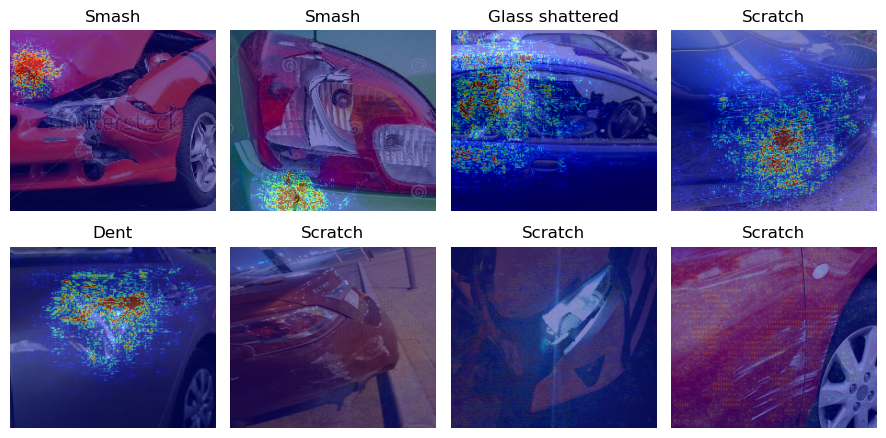

In [10]:
overlays = [] 
predictions = []

for test_image in os.listdir(DATA_PATHS["inference"]): 
    img = cv2.imread(os.path.join(DATA_PATHS["inference"], test_image))
    input_tensor = tf.convert_to_tensor(np.expand_dims(np.array(img), 0), dtype=tf.float32)

    overlay, prediction = generate_saliency_map(detection_model, input_tensor)
    
    overlays.append(overlay)
    predictions.append(prediction)

plot_results(predictions, overlays)